# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
import os
from safetensors.torch import save_file
import onnx
import onnxruntime
from torchinfo import summary

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)

Seed set to 42


42

# Device Agnostic Code

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Model Code

In [4]:
class CNNModel(nn.Module):
    """
    A convolutional neural network designed for MNIST digit classification.
    
    Architecture explanation:
    - Two convolutional layers with ReLU activation and max pooling
    - Dropout for regularization to prevent overfitting
    - Two fully connected layers for final classification
    - This design balances performance with simplicity
    """
    def __init__(self, num_classes=10, dropout_rate=0.25):
        super(CNNModel, self).__init__()
        
        # First convolutional block: extracts basic features like edges
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block: combines features into more complex patterns
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout for regularization - randomly sets some neurons to 0 during training
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Fully connected layers for final classification
        # 64 * 7 * 7 comes from: 28x28 -> 14x14 (pool1) -> 7x7 (pool2) with 64 channels
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # First conv block with ReLU activation and pooling
        x = self.pool1(F.relu(self.conv1(x)))
        
        # Second conv block with ReLU activation and pooling
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        
        # Apply dropout and first fully connected layer
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        
        # Apply dropout and final classification layer
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

# Lightning class for training 

In [5]:
class MNISTLightningModule(pl.LightningModule):
    """
    PyTorch Lightning module that wraps our CNN model.
    
    This handles training, validation, and testing logic, along with
    optimization and metric tracking. Lightning abstracts away much
    of the boilerplate code while maintaining flexibility.
    """
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.model = model.to(device)
        self.learning_rate = learning_rate
        self.save_hyperparameters(ignore=['model'])
        
        # Lists to store metrics for plotting
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        """
        Defines what happens in one training step.
        We calculate loss and accuracy, then log them for monitoring.
        """
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        accuracy = torch.sum(preds == y).float() / len(y)
        
        # Log metrics - Lightning handles the averaging across batches
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        Validation step - similar to training but without gradient updates.
        This helps us monitor overfitting and decide when to stop training.
        """
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = torch.sum(preds == y).float() / len(y)
        
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        """
        Test step for final evaluation on unseen data.
        """
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = torch.sum(preds == y).float() / len(y)
        
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_accuracy', accuracy, on_epoch=True)
        
        return loss
    
    def on_train_epoch_end(self):
        """
        Called at the end of each training epoch.
        We collect metrics here for plotting later.
        
        Important: We only collect metrics when both training and validation
        have completed to ensure synchronized arrays for plotting.
        """
        # Only collect metrics if we have validation metrics available
        if hasattr(self.trainer, 'logged_metrics'):
            train_loss = self.trainer.logged_metrics.get('train_loss_epoch', None)
            train_acc = self.trainer.logged_metrics.get('train_accuracy_epoch', None)
            
            if train_loss is not None and train_acc is not None:
                # Store these temporarily, will be added in validation epoch end
                self.temp_train_loss = float(train_loss)
                self.temp_train_acc = float(train_acc)
    
    def on_validation_epoch_end(self):
        """
        Called at the end of each validation epoch.
        We collect both train and validation metrics here to ensure synchronization.
        """
        val_loss = self.trainer.logged_metrics.get('val_loss', None)
        val_acc = self.trainer.logged_metrics.get('val_accuracy', None)
        
        # Only append if we have both train and validation metrics
        if (val_loss is not None and val_acc is not None and 
            hasattr(self, 'temp_train_loss') and hasattr(self, 'temp_train_acc')):
            
            # Add both train and validation metrics together
            self.train_losses.append(self.temp_train_loss)
            self.train_accuracies.append(self.temp_train_acc)
            self.val_losses.append(float(val_loss))
            self.val_accuracies.append(float(val_acc))
            
            # Clean up temporary storage
            delattr(self, 'temp_train_loss')
            delattr(self, 'temp_train_acc')
    
    def configure_optimizers(self):
        """
        Configure the optimizer. Adam is a good default choice as it
        adapts the learning rate automatically and works well with CNNs.
        """
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Optional: Learning rate scheduler for better convergence
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }


# Data Preparation

In [6]:
def prepare_data():
    """
    Prepare the MNIST dataset with proper transforms.
    
    Normalization is crucial because:
    1. It ensures all input values are in a similar range
    2. It helps the model converge faster and more stably
    3. The values (0.1307, 0.3081) are the mean and std of MNIST
    """
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL Image to tensor and scale to [0,1]
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST statistics
    ])
    
    # Download and create datasets
    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    # Split training data into train and validation sets
    # Using 50k for training and 10k for validation
    train_size = 50000
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    return train_dataset, val_dataset, test_dataset

# data loaders

In [7]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=64):
    """
    Create data loaders for efficient batch processing.
    
    batch_size=64 is a good balance between memory usage and gradient stability.
    num_workers=4 enables parallel data loading for faster training.
    """
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        persistent_workers=True
    )
    
    return train_loader, val_loader, test_loader

In [8]:
def get_model_size_mb(model):
    """
    Calculate model size in MB and return parameter count.
    
    This function uses torchinfo to get detailed model statistics,
    then extracts the size in MB and total parameter count.
    
    Returns:
        tuple: (size_in_mb, total_parameters)
    """
    # Get model statistics using torchinfo
    model_stats = summary(model, input_size=(1, 1, 28, 28), verbose=0)
    model_summary = str(model_stats)
    print(model_summary)  # Print the model summary for reference
    
    # Extract total parameters
    total_params = model_stats.total_params
    
    # Calculate size in MB
    # Each parameter is typically 4 bytes (32-bit float)
    size_bytes = total_params * 4
    size_mb = size_bytes / (1024 * 1024)  # Convert bytes to MB
    
    return size_mb, total_params

# plotting test/validation loss and accuracy curves

In [9]:
def plot_training_history(lightning_model, save_path='training_plots.png'):
    """
    Plot training and validation loss/accuracy curves with robust error handling.
    
    These plots help us understand:
    1. Whether the model is learning (decreasing loss, increasing accuracy)
    2. Whether we have overfitting (train metrics much better than val metrics)
    3. When to stop training (when validation metrics plateau)
    
    The function includes safety checks to handle mismatched array lengths
    that can occur due to timing differences in Lightning's callback system.
    """
    # Safety check: ensure all metric arrays have the same length
    min_length = min(
        len(lightning_model.train_losses),
        len(lightning_model.train_accuracies),
        len(lightning_model.val_losses),
        len(lightning_model.val_accuracies)
    )
    
    if min_length == 0:
        print("Warning: No metrics collected during training. Skipping plot generation.")
        return
    
    # Trim all arrays to the same length to ensure consistent plotting
    train_losses = lightning_model.train_losses[:min_length]
    train_accuracies = lightning_model.train_accuracies[:min_length]
    val_losses = lightning_model.val_losses[:min_length]
    val_accuracies = lightning_model.val_accuracies[:min_length]
    
    epochs = range(1, min_length + 1)
    
    print(f"Plotting metrics for {min_length} epochs")
    print(f"Final training loss: {train_losses[-1]:.4f}")
    print(f"Final validation loss: {val_losses[-1]:.4f}")
    print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss with enhanced styling
    ax1.plot(epochs, train_losses, 'bo-', label='Training Loss', linewidth=2, markersize=6)
    ax1.plot(epochs, val_losses, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
    ax1.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)  # Loss should start from 0
    
    # Plot accuracy with enhanced styling
    ax2.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
    ax2.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
    ax2.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])  # Accuracy should be between 0 and 1
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Training plots saved to {save_path}")


# Quantize your Model

In [10]:
def quantize_model(model):
    """
    Apply dynamic quantization to reduce model size and improve inference speed.
    
    Quantization converts 32-bit floating point weights to 8-bit integers,
    significantly reducing model size with minimal accuracy loss.
    """
    # Set model to evaluation mode for quantization
    model.eval()
    
    # Apply dynamic quantization to linear layers
    quantized_model = torch.quantization.quantize_dynamic(
        model, 
        {nn.Linear}, 
        dtype=torch.qint8
    )
    
    return quantized_model


# Prune Your Model

In [11]:
def prune_model(model, amount=0.2):
    """
    Apply structured pruning to remove less important connections.
    
    Pruning removes weights with small magnitudes, which often have
    minimal impact on model performance but reduce computation.
    
    This function carefully handles the pruning process to avoid
    state_dict compatibility issues with quantized models.
    """
    # Create a copy of the model to avoid modifying the original
    import copy
    pruned_model = copy.deepcopy(model)
    
    # Apply global magnitude pruning to convolutional and linear layers
    parameters_to_prune = []
    
    for name, module in pruned_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Only prune if the module has the standard weight parameter
            if hasattr(module, 'weight') and not hasattr(module, 'weight_mask'):
                parameters_to_prune.append((module, 'weight'))
    
    if parameters_to_prune:
        # Global magnitude pruning removes the smallest weights across all layers
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=amount,
        )
        
        # Make pruning permanent by removing the forward hooks
        for module, param in parameters_to_prune:
            prune.remove(module, param)
    
    return pruned_model


# Evaluate your model

In [12]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate model accuracy on test set.
    This helps us verify that optimization didn't hurt performance too much.
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


# Save model in different formats

In [13]:
def save_model_formats(model, model_path_base, input_shape=(1, 1, 28, 28)):
    """
    Save model in three different formats for different deployment scenarios.
    
    1. .pth: PyTorch native format, best for PyTorch inference
    2. SafeTensors: Secure format that prevents code execution attacks
    3. ONNX: Cross-platform format for deployment on various frameworks
    """
    # Ensure model is in evaluation mode
    model.eval()
    
    # 1. Save as PyTorch .pth format
    pth_path = f"{model_path_base}.pth"
    torch.save(model.state_dict(), pth_path)
    print(f"Model saved as PyTorch format: {pth_path}")
    
    # 2. Save as SafeTensors format
    safetensor_path = f"{model_path_base}.safetensors"
    save_file(model.state_dict(), safetensor_path)
    print(f"Model saved as SafeTensors format: {safetensor_path}")
    
    # 3. Save as ONNX format
    onnx_path = f"{model_path_base}.onnx"
    dummy_input = torch.randn(input_shape)
    
    try:
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )
        print(f"Model saved as ONNX format: {onnx_path}")
        
        # Verify ONNX model
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        print("ONNX model verification passed!")
        
    except Exception as e:
        print(f"Failed to save ONNX model: {e}")


# Main Function

In [14]:
def main():
    """
    Main training and optimization pipeline.
    """
    print("Starting MNIST CNN Training with PyTorch Lightning")
    print("=" * 60)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    print("\n1. Preparing datasets...")
    train_dataset, val_dataset, test_dataset = prepare_data()
    train_loader, val_loader, test_loader = create_data_loaders(
        train_dataset, val_dataset, test_dataset
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Create model
    print("\n2. Creating model...")
    cnn_model = CNNModel()
    lightning_model = MNISTLightningModule(cnn_model, learning_rate=0.001)
    
    # Calculate initial model size
    initial_size_mb, initial_params = get_model_size_mb(cnn_model)
    print(f"Initial model size: {initial_size_mb:.2f} MB ({initial_params:,} parameters)")
    
    # Setup callbacks for early stopping and model checkpointing
    early_stop_callback = EarlyStopping(
        monitor='val_loss',        # Monitor validation loss
        min_delta=0.001,          # Minimum change to qualify as improvement
        patience=5,               # Number of epochs with no improvement before stopping
        verbose=True,
        mode='min'                # Stop when monitored metric stops decreasing
    )
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_accuracy',
        dirpath='./checkpoints',
        filename='mnist-cnn-{epoch:02d}-{val_accuracy:.3f}',
        save_top_k=1,
        mode='max'
    )
    
    # Setup trainer
    trainer = pl.Trainer(
        max_epochs=20,
        callbacks=[early_stop_callback, checkpoint_callback],
        logger=TensorBoardLogger('lightning_logs', name='mnist_cnn'),
        accelerator='auto',  # Automatically choose GPU if available
        devices=1,
        deterministic=True   # For reproducible results
    )
    
    # Train the model
    print("\n3. Training model...")
    trainer.fit(lightning_model, train_loader, val_loader)
    
    # Test the model
    print("\n4. Testing model...")
    test_results = trainer.test(lightning_model, test_loader)
    original_accuracy = test_results[0]['test_accuracy']
    print(f"Original model test accuracy: {original_accuracy:.4f}")
    
    # Plot training history
    print("\n5. Plotting training history...")
    plot_training_history(lightning_model)
    
    # Extract the trained model for optimization
    trained_model = lightning_model.model
    
    # Quantization
    print("\n6. Applying quantization...")
    quantized_model = quantize_model(trained_model)
    quantized_size_mb, quantized_params = get_model_size_mb(quantized_model)
    print(f"Quantized model size: {quantized_size_mb:.2f} MB ({quantized_params:,} parameters)")
    print(f"Size reduction: {((initial_size_mb - quantized_size_mb) / initial_size_mb * 100):.1f}%")
    
    # Test quantized model accuracy
    quantized_accuracy = evaluate_model(quantized_model, test_loader, device)
    print(f"Quantized model accuracy: {quantized_accuracy:.2f}%")
    
    # Pruning with careful handling of quantized models
    print("\n7. Applying pruning...")
    
    # Important: We need to work with a copy of the original trained model
    # before quantization, because quantized models have different parameter structures
    print("Creating base model for pruning experiments...")
    
    # Start fresh with the original trained model architecture
    base_model_for_pruning = CNNModel()
    base_model_for_pruning.load_state_dict(trained_model.state_dict())
    base_model_for_pruning.eval()
    
    # Test different pruning amounts on the original model first
    best_pruned_model = None
    best_accuracy = 0
    final_prune_amount = 0
    
    prune_amounts = [0.1, 0.15, 0.2, 0.25]  # Try different pruning amounts
    
    print("Testing different pruning levels...")
    for prune_amount in prune_amounts:
        print(f"Testing {prune_amount*100:.0f}% pruning...")
        
        # Create a copy for this pruning experiment
        test_model = CNNModel()
        test_model.load_state_dict(trained_model.state_dict())
        test_model = prune_model(test_model, prune_amount)
        
        # Test accuracy on original (non-quantized) pruned model
        test_accuracy = evaluate_model(test_model, test_loader, device)
        accuracy_drop = original_accuracy - (test_accuracy / 100)
        
        print(f"  Pruning {prune_amount*100:.0f}%: Accuracy = {test_accuracy:.2f}%, Drop = {accuracy_drop*100:.2f}%")
        
        if accuracy_drop <= 0.03 and test_accuracy > best_accuracy:  # Less than 3% drop
            best_pruned_model = test_model
            best_accuracy = test_accuracy
            final_prune_amount = prune_amount
        elif accuracy_drop > 0.03:
            print(f"  Stopping: accuracy drop ({accuracy_drop*100:.2f}%) exceeds 3% threshold")
            break
    
    if best_pruned_model is None:
        print("Warning: No pruning level met the 3% accuracy threshold. Using unpruned model.")
        best_pruned_model = base_model_for_pruning
        best_accuracy = evaluate_model(base_model_for_pruning, test_loader, device)
        final_prune_amount = 0
    
    # Now apply quantization to the best pruned model
    print(f"\nApplying quantization to model pruned at {final_prune_amount*100:.0f}%...")
    final_optimized_model = quantize_model(best_pruned_model)
    final_accuracy = evaluate_model(final_optimized_model, test_loader, device)
    
    # Final model size calculation
    final_size_mb, final_params = get_model_size_mb(final_optimized_model)
    print(f"\nFinal optimized model size: {final_size_mb:.2f} MB ({final_params:,} parameters)")
    print(f"Final model accuracy: {final_accuracy:.2f}%")
    print(f"Total size reduction: {((initial_size_mb - final_size_mb) / initial_size_mb * 100):.1f}%")
    
    # Save models in multiple formats
    print("\n8. Saving models in multiple formats...")
    os.makedirs('./saved_models', exist_ok=True)
    
    # Save original model
    save_model_formats(trained_model, './saved_models/mnist_cnn_original')
    
    # Save optimized model (note: ONNX export may not work with quantized models)
    try:
        save_model_formats(final_optimized_model, './saved_models/mnist_cnn_optimized')
    except Exception as e:
        print(f"Note: Could not save quantized model in all formats due to: {e}")
        print("Saving pruned model before quantization instead...")
        save_model_formats(best_pruned_model, './saved_models/mnist_cnn_pruned_only')
    
    print("\n" + "=" * 60)
    print("Training and optimization complete!")
    print(f"Original accuracy: {original_accuracy:.4f}")
    print(f"Final accuracy: {final_accuracy/100:.4f}")
    print(f"Accuracy preserved: {((final_accuracy/100)/original_accuracy)*100:.1f}%")
    print(f"Model size reduced by: {((initial_size_mb - final_size_mb) / initial_size_mb * 100):.1f}%")
    print(f"Pruning level applied: {final_prune_amount*100:.0f}%")


# Run traning Loop

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting MNIST CNN Training with PyTorch Lightning
Using device: cpu

1. Preparing datasets...
Training samples: 50000
Validation samples: 10000
Test samples: 10000

2. Creating model...
Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Dropout: 1-5                           [1, 3136]                 --
├─Linear: 1-6                            [1, 128]                  401,536
├─Dropout: 1-7                           [1, 128]                  --
├─Linear: 1-8                            [1, 10]                   1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
Total mult-adds (Units.

c:\Users\Raunak Gola\MNIST-Studio\backend\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | CNNModel | 421 K  | train
-------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 782/782 [00:32<00:00, 24.43it/s, v_num=0, train_loss_step=0.114, train_accuracy_step=1.000, val_loss=0.0595, val_accuracy=0.981, train_loss_epoch=0.188, train_accuracy_epoch=0.942]

Metric val_loss improved. New best score: 0.060


Epoch 1: 100%|██████████| 782/782 [00:32<00:00, 23.84it/s, v_num=0, train_loss_step=0.00208, train_accuracy_step=1.000, val_loss=0.0487, val_accuracy=0.986, train_loss_epoch=0.0662, train_accuracy_epoch=0.979]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.049


Epoch 2: 100%|██████████| 782/782 [00:33<00:00, 23.60it/s, v_num=0, train_loss_step=0.0231, train_accuracy_step=1.000, val_loss=0.0384, val_accuracy=0.988, train_loss_epoch=0.0516, train_accuracy_epoch=0.985] 

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.038


Epoch 6: 100%|██████████| 782/782 [00:35<00:00, 21.89it/s, v_num=0, train_loss_step=0.230, train_accuracy_step=0.938, val_loss=0.0356, val_accuracy=0.991, train_loss_epoch=0.0275, train_accuracy_epoch=0.991]   

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.036


Epoch 7: 100%|██████████| 782/782 [00:34<00:00, 22.45it/s, v_num=0, train_loss_step=0.119, train_accuracy_step=0.938, val_loss=0.0324, val_accuracy=0.991, train_loss_epoch=0.0267, train_accuracy_epoch=0.992]   

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.032


Epoch 12: 100%|██████████| 782/782 [00:38<00:00, 20.38it/s, v_num=0, train_loss_step=3.15e-6, train_accuracy_step=1.000, val_loss=0.035, val_accuracy=0.992, train_loss_epoch=0.0115, train_accuracy_epoch=0.996]  

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.032. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 782/782 [00:38<00:00, 20.37it/s, v_num=0, train_loss_step=3.15e-6, train_accuracy_step=1.000, val_loss=0.035, val_accuracy=0.992, train_loss_epoch=0.0115, train_accuracy_epoch=0.996]

4. Testing model...
Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 54.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9932000041007996
        test_loss          0.023235129192471504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Original model test accuracy: 0.9932

5. Plotting training history...
Plotting metrics for 12 epochs
Final training loss: 0.0177
Final validation loss: 0.0350
Final training accuracy: 0.9941
Fina

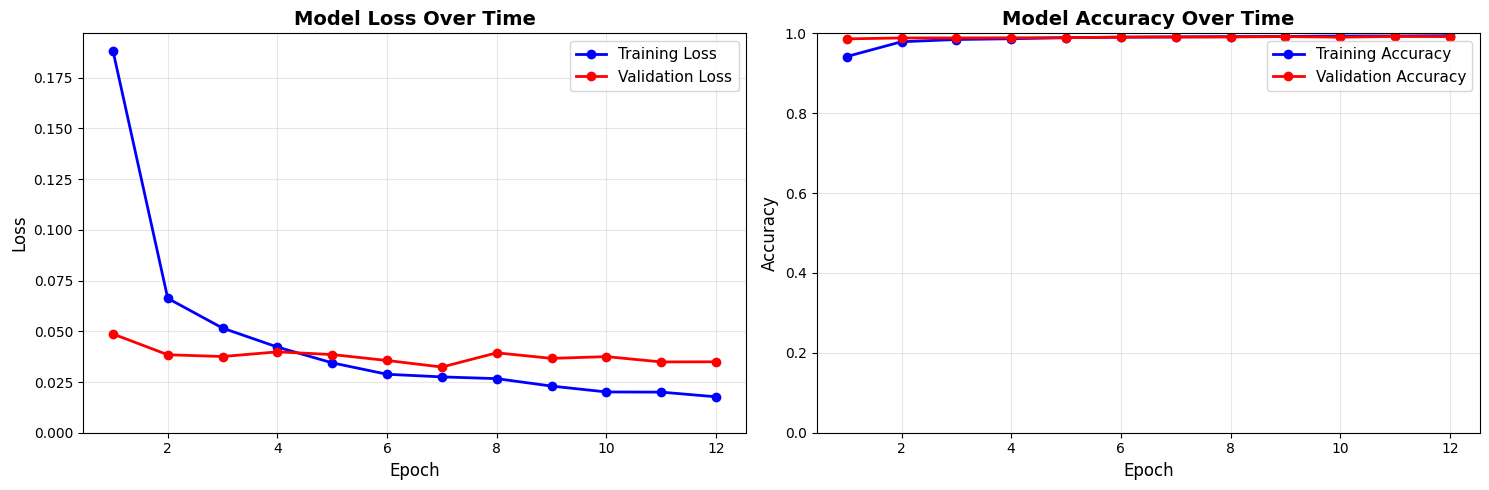

Training plots saved to training_plots.png

6. Applying quantization...
Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Dropout: 1-5                           [1, 3136]                 --
├─Linear: 1-6                            [1, 128]                  --
├─Dropout: 1-7                           [1, 128]                  --
├─Linear: 1-8                            [1, 10]                   --
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.08
Estimated Total Size (MB)

In [15]:
if __name__ == "__main__":
    main()